In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

import statsmodels.api as sm

/home/joaovictor/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0, "legend.title_fontsize": 13.75}
sns.set (style="whitegrid", font_scale=1.35, rc=myrcs)
sns.set_palette (sns.color_palette (["#b2df8a", "#33a02c", "#cab2d6", "#6a3d9a"]))
sns.set_palette (sns.color_palette (["#b2df8a", "#33a02c", "#fdbf6f", "#ff7f00"]))
sns.set_palette (sns.color_palette ("Paired"))




# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
#Configurações
# A1 - com switch HW, não podendo aumentar/diminuir número de switches SW (número máximo de SW = 1)
# A5 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)
# B - sem switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)
# D - com switch HW, não podendo aumentar/diminuir número de switches SW (número de SW fixo em 5)
# E - sem switch HW, não podendo aumentar/diminuir número de switches SW (número de SW fixo em 5)

#Nomes das configurações nos gráficos:
# D = (HW = 1; SW = 5); B = (HW = 0; SW = 1-5); A5 = (HW = 1; SW = 1-5); E = (HW = 0; SW = 5)

# Parâmetros que variam nesta simulação
seeds = [1,2]
cargas = ["150hosts"] #"50hosts", "100hosts",
experimentos = ["a5"]

# Tempo total de simulação
t_sim = 2000

# Intervalo de confiança
confianca = 99

# Imprimir titulos nos gráficos
titulos = False

# Salvar graficos
salvarGraficos = False

In [4]:
def read_df_saidaStruct ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-saidaStruct.log", sep='\s+', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_cache ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-traffic-qos-l7-app.log", sep='\s+', index_col=["Teid"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_ping ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/ping/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingStats.zip", sep='\s+', compression='zip', index_col=["Cookie"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Load","Experimento","Seed","Cookie"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

In [5]:
df_ping = read_df_ping()
#df_ping

Time:s   Delay:ns  Jitter:ns
Load Experimento Seed Cookie                                          
High a5          1    0x032031276a758a11   201.2  1804848.0   112803.0
                      0x032031276a758a11   201.2  1804848.0   105752.0
                      0x032031276a758a11   201.3  1804848.0    99142.0
                      0x032031276a758a11   201.3  1804848.0    92945.0
                      0x032031276a758a11   201.3  1784848.0    88385.0
                      0x07a079276d758d11   201.3  1784848.0   111553.0
                      0x032031276a758a11   201.3  1784848.0    82860.0
                      0x03e03d276c758c11   201.3  1784848.0   111553.0
                      0x07a079276d758d11   201.3  1784848.0   104580.0
                      0x032031276a758a11   201.3  1784848.0    77681.0
...                                          ...        ...        ...
                 2    0x06a06927e8760811   496.6  1764848.0        0.0
                      0x06a06927e8760811   496.7  1764848.0        0.0
                      0x06a06927e8760811   496.7  1764848.0        0.0
                      0x06a06927e8760811   496.8  1764848.0        0.0
                      0x06a06927e8760811   496.8  1764848.0        0.0
                      0x06a06927e8760811   496.9  1764848.0        0.0
                      0x06a06927e8760811   496.9  1764848.0        0.0
                      0x06a06927e8760811   497.0  1764848.0        0.0
                      0x06a06927e8760811   497.0  1764848.0        0.0
                      0x06a06927e8760811   497.1  1764848.0        0.0

[13699307 rows x 3 columns]

In [6]:
df_saidaStruct = read_df_saidaStruct()
df_saidaStruct.drop(columns=["SRCIP", "DSTIP", "SRCPort", "DSTPort","Protocol","NumSwitches", "Active","Blocked", "Direction", "TimeCreated", "TimeFinished", "ExpBytes", "Rate"],inplace=True)
#df_saidaStruct

InCache
Load Experimento Seed Cookie                     
High a5          1    0x0040032710753011        1
                      0x0040032711753111        1
                      0x0040032712753211        1
                      0x0040032713753311        1
                      0x0040032714753411        1
                      0x0040032715753511        1
                      0x0040032716753611        1
                      0x0040032717753711        1
                      0x0040032718753811        0
                      0x0040032719753911        0
...                                           ...
                 2    0x12e12d2800762011        0
                      0x12e12d2801762111        1
                      0x12e12d2802762211        0
                      0x12e12d2803762311        0
                      0x12e12d2804762411        0
                      0x12e12d2805762511        1
                      0x12e12d2806762611        1
                      0x12e12d2807762711        1
                      0x12e12d2808762811        0
                      0x12e12d2809762911        1

[74988 rows x 1 columns]

In [7]:
df_concatenado = pd.merge(df_ping, df_saidaStruct, how='left', on = ['Cookie', 'Load','Experimento', 'Seed'])
df_concatenado.reset_index(inplace=True)
#df_concatenado

,Cookie,Load,Experimento,Seed,Time:s,Delay:ns,Jitter:ns,InCache
0,0x032031276a758a11,High,a5,1,201.2,1804848.0,112803.0,0
1,0x032031276a758a11,High,a5,1,201.2,1804848.0,105752.0,0
2,0x032031276a758a11,High,a5,1,201.3,1804848.0,99142.0,0
3,0x032031276a758a11,High,a5,1,201.3,1804848.0,92945.0,0
4,0x032031276a758a11,High,a5,1,201.3,1784848.0,88385.0,0
5,0x07a079276d758d11,High,a5,1,201.3,1784848.0,111553.0,0
6,0x032031276a758a11,High,a5,1,201.3,1784848.0,82860.0,0
7,0x03e03d276c758c11,High,a5,1,201.3,1784848.0,111553.0,0
8,0x07a079276d758d11,High,a5,1,201.3,1784848.0,104580.0,0
9,0x032031276a758a11,High,a5,1,201.3,1784848.0,77681.0,0


In [8]:
df_movido = df_concatenado.query("InCache == 1")
df_movido

,Cookie,Load,Experimento,Seed,Time:s,Delay:ns,Jitter:ns,InCache
170,0x0580572779759911,High,a5,1,202.0,1784848.0,111553.0,1
171,0x0580572779759911,High,a5,1,202.0,1784848.0,104580.0,1
176,0x0580572779759911,High,a5,1,202.0,1784848.0,98043.0,1
179,0x0580572779759911,High,a5,1,202.0,1784848.0,91915.0,1
181,0x0580572779759911,High,a5,1,202.0,1784848.0,86170.0,1
182,0x0580572779759911,High,a5,1,202.0,1784848.0,80784.0,1
185,0x0580572779759911,High,a5,1,202.0,1784848.0,75735.0,1
187,0x0580572779759911,High,a5,1,202.0,1784848.0,71001.0,1
188,0x0580572779759911,High,a5,1,202.0,1784848.0,66563.0,1
191,0x0580572779759911,High,a5,1,202.0,1784848.0,62402.0,1


In [9]:
df_naoMovido = df_concatenado.query("InCache == 0")
df_naoMovido

,Cookie,Load,Experimento,Seed,Time:s,Delay:ns,Jitter:ns,InCache
0,0x032031276a758a11,High,a5,1,201.2,1804848.0,112803.0,0
1,0x032031276a758a11,High,a5,1,201.2,1804848.0,105752.0,0
2,0x032031276a758a11,High,a5,1,201.3,1804848.0,99142.0,0
3,0x032031276a758a11,High,a5,1,201.3,1804848.0,92945.0,0
4,0x032031276a758a11,High,a5,1,201.3,1784848.0,88385.0,0
5,0x07a079276d758d11,High,a5,1,201.3,1784848.0,111553.0,0
6,0x032031276a758a11,High,a5,1,201.3,1784848.0,82860.0,0
7,0x03e03d276c758c11,High,a5,1,201.3,1784848.0,111553.0,0
8,0x07a079276d758d11,High,a5,1,201.3,1784848.0,104580.0,0
9,0x032031276a758a11,High,a5,1,201.3,1784848.0,77681.0,0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:903: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, **kwargs)


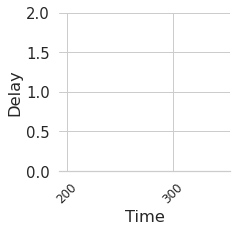

In [11]:
snsplt = sns.relplot( x="Time:s", y="Delay:ns", height=3.5, aspect=1.1,
            kind="line", data=df_movido, ci=confianca)
snsplt.set_titles("title")
snsplt.set_axis_labels("Time", "Delay")
if (titulos):
    snsplt.fig.suptitle('title', y=1.05)
snsplt.set(ylim=(0,2))
snsplt.set_xticklabels(rotation=45, size=12)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("nome.pdf")

In [ ]:
snsplt = sns.catplot( x="Time:s", y="Jitter:ns", kind="bar",  height=3.5, aspect=1,
                      ci=confianca, data=df_naoMovido, row="Experimento")
snsplt.set_titles("{row_name}")
snsplt.set_axis_labels("Time", "Jitter")
if (titulos):
    snsplt.fig.suptitle('title', y=1.05)
snsplt.set(ylim=(0,0.003))
snsplt.set_xticklabels(rotation=45, size=12)
#snsplt.fig.set_size_inches(11,4)
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("nome.pdf")